# Drive Connection


In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries



In [2]:
import tensorflow as tf
print(tf.__version__)
import sys,os
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from tqdm.notebook import tqdm
import re
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

# models
from sklearn import linear_model, naive_bayes, neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Dropout, BatchNormalization, MaxPool1D, Conv1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D

# stat libraries
from scipy import stats

# Libraries for the evaluation
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline

2.6.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
sample_rate = 16000
n_features = 20
def extract_features(audio):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_features)
    return mfccs   # it returns a np.array with size (n_features,'t') where t is the number of audio frames.

In [4]:
# there are 2703 audio files (ext: .flac)
root = "/content/drive/MyDrive/LibriSpeech/dev-clean"
df = pd.DataFrame(columns=['speaker_id', 'features', 'mean_features', 'feature_len'])      

In [5]:
df.shape

(0, 4)

In [6]:
df.head()

,speaker_id,features,mean_features,feature_len


In [7]:
i = 0
# max_pad_len = 1021
# loading the features in the first dataframe
for path, subdirs, files in os.walk(root):
    for name in files:
        if name.endswith(".flac"):
          speaker_id = path.split('/')[-2]
          sound, sr = sf.read(os.path.join(path, name)) 
          data = extract_features(sound)
          mean = data.mean(axis=1)
          # zero-pad the mfccs features in order to have all compatible shapes for input of the CNN.
          # max_pad_len is the biggest number of audio frames
          # obtained by extracting features (mfccs) from all the audio files.
          # pad_width = max_pad_len - data.shape[1]
          # data = np.pad(data, pad_width=((0,0), (0, pad_width)), mode='constant')
          df.loc[i] = [speaker_id] + [data] + [mean] + [data.shape[-1]]
          i += 1
          # print(i)

In [8]:
df.shape

(2703, 4)

In [9]:
            
# loading the labels in the second dataframe
root = "/content/drive/MyDrive/LibriSpeech/"
labels = pd.DataFrame(columns=['speaker_id', 'gender'])

f = open("/content/drive/MyDrive/LibriSpeech/SPEAKERS.TXT", "r", encoding="UTF8").readlines()
i = 0
for idx, line in enumerate(f):
  if idx > 11:
    parsed = re.split('\s+',line)
    if parsed[4] == 'dev-clean':
      labels.loc[i] = parsed[0], parsed[2] # speaker_id and label (M/F)
      i += 1   


In [10]:
labels.shape

(40, 2)

In [11]:
dataset = pd.merge(df, labels, on='speaker_id')  # merging the two dataframes.

# REPLACE CATEGORICAL VALUES INTO NUMERIC VALUES
dataset["gender"].replace({"M": 1, "F": 0}, inplace=True)
dataset.head(5)

,speaker_id,features,mean_features,feature_len,gender
0,84,"[[-496.89234875492144, -476.48069672791394, -4...","[-258.8246089785458, 103.87397462207245, -0.76...",149,0
1,84,"[[-497.26437359421, -491.91095208994074, -490....","[-277.8363737795311, 85.01179562907777, 6.4026...",196,0
2,84,"[[-472.73129778864404, -478.1253176789915, -49...","[-275.2079016757408, 85.35834034116208, 10.368...",293,0
3,84,"[[-505.3398486839001, -502.4408384539761, -504...","[-306.6638471622918, 105.45939917679402, 0.232...",82,0
4,84,"[[-511.71966908933877, -504.6651393416577, -50...","[-316.33891555695493, 76.52286736768811, 9.761...",213,0


In [12]:
dataset['gender'].value_counts()


0    1374
1    1329
Name: gender, dtype: int64

In [13]:
len(dataset)

2703

# Train / Test Split 

In [14]:
train_test_ratio = 0.95
n_sounds = len(dataset)

def split_train_test(train_test_ratio, n_sounds):
    
    train = pd.DataFrame(columns=['speaker_id', 'features' , 'gender'])
    test = pd.DataFrame(columns=['speaker_id', 'features', 'gender'])
    
    train_elems = int(np.floor(n_sounds*train_test_ratio))
    test_elems = n_sounds - train_elems
    
    print("Splitting ratio: ",train_test_ratio)
    print("Expected audio in the train: ", train_elems)
    print("Expected audio in the test: ", test_elems)
    print("Total audios: ", n_sounds)
    
    """
    EXPLANATION:
    so, there are 20 males speakers (1374 audio files) and 20 female speakers (1329 audio files).
    
    first run:
        - until is not reached the 0.8 (=split ratio) * number of audio of males...
        - ...keep adding all the audio of each MALE speaker (almost 16 speakers)
        - Then, adds the audio of the remaining (4) speakers to the test
        
    second run:
        - until the train set doesn't have enough audio (so, 0.8 * total number of audio)...
        - ...keep adding all the audio of each FEMALE speaker
        - Then, adds the audio of the remaining speakers to the test.
        
    
    Now train and test have a balanced number of male and female speakers... and independent samples.
    """

    male_train = int(np.floor(dataset['gender'].value_counts()[0]* train_test_ratio))
    male_test = int(np.ceil(dataset['gender'].value_counts()[0]* (1-train_test_ratio)))
    train_sizes = [male_train, train_elems]
    test_sizes = [male_test + male_train, n_sounds]
    
    for gender in range(2):  
        if gender == 0:
            gender_set = dataset[dataset["gender"] == gender]   # MALES
        elif gender == 1:
            gender_set = dataset[dataset["gender"] == gender]   # FEMALES

        ordered_gender_set = gender_set['speaker_id'].value_counts()
        i = 0
        while (train.shape[0] < train_sizes[gender]):
            train = train.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
        while (test.shape[0] + train.shape[0] != test_sizes[gender]): 
            test = test.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
            
    # Since we are inserting a speaker (and all its related audio files) per time, 
    # the splitting ratio might slightly differ:
    print("\nActual splitting ratio: {:.3f}".format(train.shape[0]/n_sounds))
    print("Actual audio in the train: ", train.shape[0])
    print("Actual audio in the test: ", test.shape[0])

    print("\nMales in the train: ", train['gender'].value_counts()[0])
    print("Males in the test: ", test['gender'].value_counts()[0])
    print("Females in the train: ", train['gender'].value_counts()[1])
    print("Females in the test: ", test['gender'].value_counts()[1])

    return train, test
   
train, test = split_train_test(train_test_ratio, n_sounds)

Splitting ratio:  0.95
Expected audio in the train:  2567
Expected audio in the test:  136
Total audios:  2703

Actual splitting ratio: 0.957
Actual audio in the train:  2588
Actual audio in the test:  115

Males in the train:  1333
Males in the test:  41
Females in the train:  1255
Females in the test:  74


In [15]:
train.head()

,speaker_id,features,gender,mean_features,feature_len
2061,6313,"[[-400.7924662973153, -396.44239799563974, -36...",0,"[-274.09137631031604, 71.95444303795435, -80.4...",182
2062,6313,"[[-355.670410546917, -350.45071405464546, -342...",0,"[-271.84440611111364, 51.16532988349791, -76.5...",93
2063,6313,"[[-417.8692871053174, -414.87253576341305, -42...",0,"[-279.76635964283923, 55.02419808562309, -60.8...",93
2064,6313,"[[-400.5826659424235, -392.81021840022214, -37...",0,"[-272.39611630881603, 60.27930214360178, -68.3...",208
2065,6313,"[[-417.46792880412187, -401.56190202613584, -3...",0,"[-278.7982185852052, 50.10121822887248, -66.00...",126


In [16]:
train.shape, test.shape

((2588, 5), (115, 5))

In [17]:
test[test.speaker_id.isin(train.speaker_id)]

,speaker_id,features,gender,mean_features,feature_len


# Data Processing


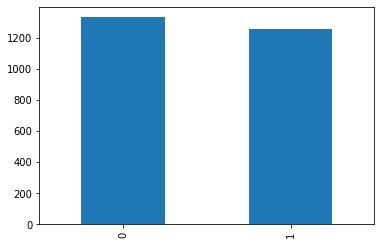

In [18]:
train.gender.value_counts().plot(kind='bar')

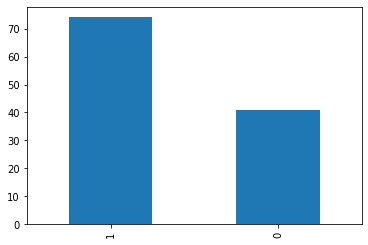

In [19]:
test.gender.value_counts().plot(kind='bar')

In [20]:
train.isnull().sum()

speaker_id       0
features         0
gender           0
mean_features    0
feature_len      0
dtype: int64

In [21]:
train.head(1)

,speaker_id,features,gender,mean_features,feature_len
2061,6313,"[[-400.7924662973153, -396.44239799563974, -36...",0,"[-274.09137631031604, 71.95444303795435, -80.4...",182


In [22]:
feature_df = pd.DataFrame(train.mean_features.tolist())

In [23]:
corr_df = feature_df.corr()

NameError: ignored

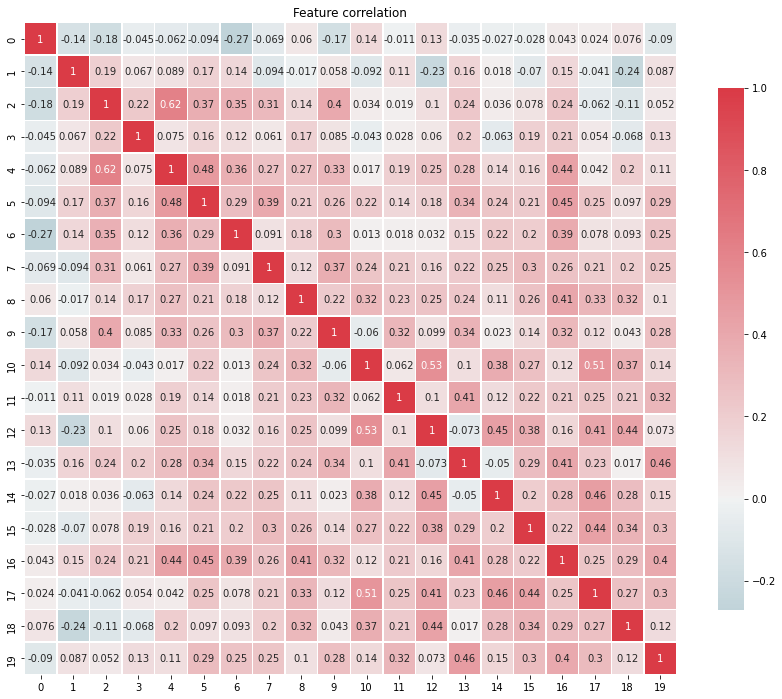

In [24]:
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr_df, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True)


ax.set_title("Feature correlation")
fig.tight_layout()
plt.show()

# Machine Learning

In [26]:
X_train = np.array(train.mean_features.tolist())
X_test = np.array(test.mean_features.tolist())
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2588, 20), (2588,), (115, 20), (115,))

In [28]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [29]:
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [30]:
from sklearn.utils import shuffle

In [31]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

# KNN

In [32]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report

In [37]:
knn = KNeighborsClassifier(5, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_knn)
print('Classification Report')
print(classification_report(y_test, y_pred))


Accuracy:  0.591304347826087
Classification Report
              precision    recall  f1-score   support

           0       0.45      0.66      0.53        41
           1       0.75      0.55      0.64        74

    accuracy                           0.59       115
   macro avg       0.60      0.61      0.59       115
weighted avg       0.64      0.59      0.60       115



# Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
nb = GaussianNB();
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))


Accuracy:  0.5304347826086957
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.60      0.82      0.69        74

    accuracy                           0.53       115
   macro avg       0.30      0.41      0.35       115
weighted avg       0.38      0.53      0.45       115



# Support Vector Machine

In [40]:
from sklearn import svm

In [41]:
svc = svm.SVC(kernel='poly', gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Confusion Matrix:")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix:

Accuracy:  0.5739130434782609
Classification Report
              precision    recall  f1-score   support

           0       0.41      0.46      0.44        41
           1       0.68      0.64      0.66        74

    accuracy                           0.57       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.59      0.57      0.58       115



# Perceptron

In [42]:
from sklearn.linear_model import Perceptron

In [43]:
knn = Perceptron(shuffle=True) # training data are shuffled at each epoch.
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))

# The Perceptron required shuffling of the training to make the gradient descent work in the proper way.

# For what concerns the other algorithms, instead, shuffling didn't bring any advantage/difference in the performances

Confusion Matrix:

Accuracy:  0.8608695652173913
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.71      0.78        41
           1       0.85      0.95      0.90        74

    accuracy                           0.86       115
   macro avg       0.87      0.83      0.84       115
weighted avg       0.86      0.86      0.86       115



# Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
log = LogisticRegression(C=1e5, solver='saga', max_iter=100, verbose=0)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print("Confusion Matrix:")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix:

Accuracy:  0.6608695652173913
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.07      0.13        41
           1       0.66      0.99      0.79        74

    accuracy                           0.66       115
   macro avg       0.70      0.53      0.46       115
weighted avg       0.69      0.66      0.56       115



# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Confusion Matrix:")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix:

Accuracy:  0.7130434782608696
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.78      0.66        41
           1       0.85      0.68      0.75        74

    accuracy                           0.71       115
   macro avg       0.71      0.73      0.71       115
weighted avg       0.75      0.71      0.72       115



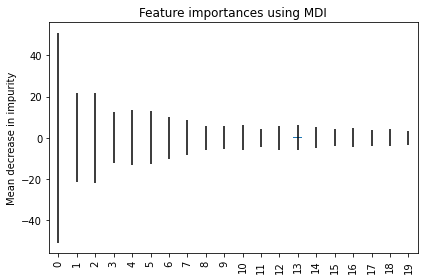

In [48]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Neural Network

In [49]:
from sklearn.neural_network import MLPClassifier

In [50]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=256, max_iter=500)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Confusion Matrix:")
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred))

Confusion Matrix:

Accuracy:  0.7652173913043478
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.41      0.56        41
           1       0.75      0.96      0.84        74

    accuracy                           0.77       115
   macro avg       0.80      0.69      0.70       115
weighted avg       0.78      0.77      0.74       115



In [51]:
def plot_history(history, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")


# Convolutional Neural Network



In [52]:
train_min_len = train.feature_len.min()
test_min_len = test.feature_len.min()

In [55]:
train_min_len, test_min_len

(46, 68)

In [98]:
len_ = 10
X_train_nn = []
y_train_nn = []
for i, row in train.iterrows():
  len = row
  for i in  range(0, row.feature_len-len_, len_):
    if i + len_ < row.feature_len:
      X_train_nn.append(row.features[:, i:(i+len_)])
  # X_train_nn.append(row.mean_features)
      y_train_nn.append(row.gender)

X_test_nn = []
y_test_nn = []
for i, row in test.iterrows():
  len = row
  for i in range(0, row.feature_len-len_, len_):
    if i + len_ < row.feature_len:
      X_test_nn.append(row.features[:, i:(i+len_)])
  # X_train_nn.append(row.mean_features)
      y_test_nn.append(row.gender)

X_train_nn = np.array(X_train_nn)
y_train_nn = np.array(y_train_nn)


y_test_nn = np.array(y_test_nn)
X_test_nn = np.array(X_test_nn)

In [99]:
X_train_nn[1324].shape

(20, 10)

In [100]:
X_train_nn.shape, y_train_nn.shape, X_test_nn.shape, y_test_nn.shape

((54772, 20, 10), (54772,), (4534, 20, 10), (4534,))

In [101]:
X_train_nn = X_train_nn.reshape(X_train_nn.shape[0], -1, 20)
X_test_nn = X_test_nn.reshape(X_test_nn.shape[0], -1, 20)

In [102]:
X_train_nn = (X_train_nn- mean[None, None, :])/std[None, None, :]
X_test_nn = (X_test_nn- mean[None, None, :])/std[None, None, :]


In [103]:
#X_train_nn = (X_train_nn- mean[None, :])/std[None, :]
#X_test_nn = (X_test_nn- mean[None, :])/std[None, :]


In [104]:
X_train_nn.shape, y_train.shape, X_test_nn.shape, y_test.shape

((54772, 10, 20), (2588,), (4534, 10, 20), (115,))

In [105]:
X_train_nn, y_train_nn = shuffle(X_train_nn, y_train_nn, random_state=1234)

In [106]:
X_train_nn = X_train_nn.reshape(X_train_nn.shape[0], len_*20)
X_test_nn = X_test_nn.reshape(X_test_nn.shape[0], len_ * 20)


model = Sequential()
model.add(Dense(16, input_dim=200, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    # Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 3,233
Trainable params: 3,233
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
score = model.evaluate(X_test_nn, y_test_nn, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 56.1976%


In [108]:
num_epochs = 20
num_batch_size = 128
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# In min mode, training will stop when the val_loss has stopped decreasing
# Patience is the number of epochs without improvement after which training will be stopped.

history = model.fit(X_train_nn, y_train_nn, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test_nn, y_test_nn), callbacks=[es])

Epoch 1/20
428/428 [==============================] - 1s 2ms/step - loss: 0.4674 - accuracy: 0.7792 - val_loss: 1.0166 - val_accuracy: 0.5132
Epoch 2/20
428/428 [==============================] - 1s 2ms/step - loss: 0.3407 - accuracy: 0.8461 - val_loss: 1.1187 - val_accuracy: 0.5300
Epoch 3/20
428/428 [==============================] - 1s 2ms/step - loss: 0.2967 - accuracy: 0.8691 - val_loss: 1.2879 - val_accuracy: 0.4971
Epoch 4/20
428/428 [==============================] - 1s 2ms/step - loss: 0.2752 - accuracy: 0.8788 - val_loss: 1.2676 - val_accuracy: 0.5212
Epoch 5/20
428/428 [==============================] - 1s 2ms/step - loss: 0.2636 - accuracy: 0.8848 - val_loss: 1.4057 - val_accuracy: 0.5055
Epoch 6/20
428/428 [==============================] - 1s 2ms/step - loss: 0.2553 - accuracy: 0.8892 - val_loss: 1.2718 - val_accuracy: 0.5357
Epoch 7/20
428/428 [==============================] - 1s 2ms/step - loss: 0.2504 - accuracy: 0.8913 - val_loss: 1.2948 - val_accuracy: 0.5225
Epoch 

In [109]:
score = model.evaluate(X_test_nn, y_test_nn, verbose=0)
accuracy_mlp = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)
print("Post-training accuracy: %.4f%%" % accuracy_mlp)

Pre-training accuracy: 56.1976%
Post-training accuracy: 53.0878%


In [543]:
X_train_nn = X_train_nn.reshape(X_train_nn.shape[0],-1, 20)
X_test_nn = X_test_nn.reshape(X_test_nn.shape[0],-1, 20)

model = Sequential()
model.add(Conv1D(16, 2, activation='relu', input_shape=(None,20)))
model.add(BatchNormalization())
# model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(Conv1D(16, 2, activation='relu', input_shape=(None, 16)))
model.add(BatchNormalization())
# model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_119 (Conv1D)          (None, None, 16)          656       
_________________________________________________________________
batch_normalization_31 (Batc (None, None, 16)          64        
_________________________________________________________________
dropout_49 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, None, 16)          528       
_________________________________________________________________
batch_normalization_32 (Batc (None, None, 16)          64        
_________________________________________________________________
dropout_50 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_max_pooling1d_44 (Glo (None, 16)              

In [544]:
score = model.evaluate(X_test_nn, y_test_nn, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 64.5652%


In [546]:
num_epochs = 20
num_batch_size = 16
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# In min mode, training will stop when the val_loss has stopped decreasing
# Patience is the number of epochs without improvement after which training will be stopped.

history = model.fit(X_train_nn, y_train_nn, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test_nn, y_test_nn), callbacks=[es])

Epoch 1/20
647/647 [==============================] - 3s 3ms/step - loss: 0.8776 - accuracy: 0.7554 - val_loss: 0.8128 - val_accuracy: 0.6435
Epoch 2/20
647/647 [==============================] - 2s 3ms/step - loss: 0.4668 - accuracy: 0.8425 - val_loss: 0.7265 - val_accuracy: 0.6435
Epoch 3/20
647/647 [==============================] - 2s 3ms/step - loss: 0.3993 - accuracy: 0.8692 - val_loss: 0.7301 - val_accuracy: 0.6435
Epoch 4/20
647/647 [==============================] - 2s 3ms/step - loss: 0.3824 - accuracy: 0.8712 - val_loss: 0.7317 - val_accuracy: 0.6435
Epoch 5/20
647/647 [==============================] - 2s 3ms/step - loss: 0.3720 - accuracy: 0.8712 - val_loss: 0.7530 - val_accuracy: 0.6435
Epoch 6/20
647/647 [==============================] - 2s 3ms/step - loss: 0.3678 - accuracy: 0.8712 - val_loss: 0.7493 - val_accuracy: 0.6435
Epoch 7/20
647/647 [==============================] - 2s 3ms/step - loss: 0.3654 - accuracy: 0.8712 - val_loss: 0.7749 - val_accuracy: 0.6435
Epoch 

In [548]:
score = model.evaluate(X_test_nn, y_test_nn, verbose=0)
accuracy_cnn = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)
print("Post-training accuracy: %.4f%%" % accuracy_cnn)

Pre-training accuracy: 64.5652%
Post-training accuracy: 64.3478%


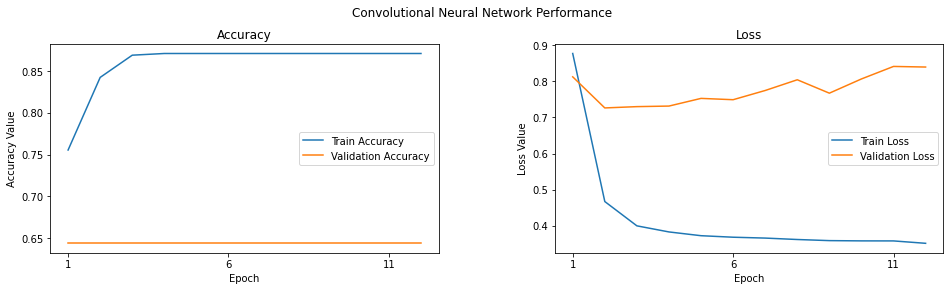

In [549]:
title='Convolutional Neural Network Performance'
plot_history(history, title)

In [551]:
print("\nK-Nearest Neighbors accuracy: %.4f%%" % (accuracy_knn*100))
print("\nNaive-Bayes accuracy: %.4f%%" % (accuracy_nb*100))
print("\nSupport Vector Machine accuracy: %.4f%%" % (accuracy_svm*100))
print("\nPerceptron: %.4f%%" % (accuracy_perceptron*100))
print("\nLogistic Regression accuracy: %.4f%%" % (accuracy_log*100))
print("\nMulti-layer Perceptron accuracy: %.4f%%" % (accuracy_mlp*100))
print("\nConvolutional Neural Network accuracy: %.4f%%" % accuracy_cnn)


K-Nearest Neighbors accuracy: 59.1304%


NameError: ignored

# TASK II


In [4]:
def token_features(token, part_of_speech):
    if token.isdigit():
        yield "numeric"
    else:
        yield "token={}".format(token.lower())
        yield "token,pos={},{}".format(token, part_of_speech)
    if token[0].isupper():
        yield "uppercase_initial"
    if token.isupper():
        yield "all_uppercase"
    yield "pos={}".format(part_of_speech)

In [27]:
#   Speaker Identification.
#   Data comes from http://www.openslr.org/12/
#   Task: Given 't' seconds of speech, identify the speaker.
#   10-class classification: 5 male and 5 female speakers.
#   Training on about 10 minutes of speech per speaker.
#
#
import soundfile as sf            # To read .flac files.   


import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For the neural network.

from pytorch.datasets                import ClassificationDataSet
from pytorch.tools.shortcuts         import buildNetwork
from pytorch.supervised.trainers     import BackpropTrainer
from pybrain.structure.modules       import SoftmaxLayer
from pybrain.tools.xml.networkreader import NetworkReader
from pybrain.tools.xml.networkwriter import NetworkWriter

from pybrain.structure import FullConnection
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer
from pybrain.structure import TanhLayer

sq = lambda x: x*x

durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz.  
audioType  = ".flac"               # Flac files. 
path       = "LibriSpeech/"        # Path where audio files are located.
trainSet   = "train-clean/"        # Training set.
cvSet      = "cv-clean/"           # Cross-Validation set.
tstSet     = "test-clean/"         # Test set. 
maxminFile = "min_max_values.dat"  # File to store max and min values for each frequency bin.
outfolder  = "networks/"           # Folder to store trained networks.
stem       = "nn"                  # Output network filename stem.    

# These are the speakers.
# Female: 19, 32, 39, 40, 83
# Male: 26, 27, 78, 405, 196
speakers = ["19/",
            "26/",
            "32/",
            "27/",
            "39/",
            "78/",
            "40/",
            "405/", 
            "83/",
            "196/"]

numFeatures = lim2-lim1
numSpeakers = len(speakers)

ModuleNotFoundError: ignored

In [552]:
# Read data from a folder into a list.
def getData(division,speaker):
  fname = path+division+speaker  
  subPaths = [v+"/" for v in os.listdir(fname) if v[0] != "."]
  dataFiles = []
  for subPath in subPaths:
    files = [v for v in os.listdir(fname+subPath) if v[0] != "." and audioType in v]
    for fil in files:
      data,samplerate = sf.read(fname+subPath+fil)  
      duration = len(data)*1./samplerate
      if duration >= durationCheck: dataFiles.append(fname+subPath+fil)
        
  chunksF = []

  for fil in dataFiles:
    data,samplerate = sf.read(fil)  
    duration = len(data)*1./samplerate

    # Divide audio data into frames, or chunks. 
    numChunks = int(duration/deltaT)
    sizeChunk = int(len(data)/numChunks)
    for lp in range(0,numChunks):    
      chunk = data[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
      chunksF.append(np.abs(np.fft.rfft(chunk))[lim1:lim2])  # take the FFT.

    # Delete quiet parts of speech, i.e. pauses.
    # Most of the power is in the bottom 50% of frequencies.
    mu = np.mean([np.mean(chunksF[i][:numFeatures//2]) for i in range(0,len(chunksF))])
    dataF = []
    for chunkF in chunksF:
      if np.mean(chunkF[:numFeatures//2]) > noisy*mu:
        dataF.append(chunkF)
    
  return dataF

# Return data for all speakers.
def getDataSpeakers(division):
  dataSpeakers = []
  for speaker in speakers:
    print ("Getting data for speaker: "+speaker)
    dataSpeakers.append(getData(division,speaker))

  N = np.sum([np.shape(s)[0] for s in dataSpeakers])
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  speakerIndices = [0]    # Index corresponding to start of speaker 'n'
  
  ctr = 0; lp = 0
  for dataSpeaker in dataSpeakers:
    for j in range(0,len(dataSpeaker)):
      for k in range(0,numFeatures):
        tX[ctr,k] = dataSpeaker[j][k]
      tY.append(lp)
      ctr += 1  
    speakerIndices.append(ctr)
    lp += 1  
          
  return tX,tY,speakerIndices